In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
import xitorch
from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path
import hickle
plt.rcParams['figure.figsize'] = 2*1.618, 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
def compute_eigenvalues(blocks, dataset, overlap_matrices = None, baseline = None):
    
    recon_HT = blocks_to_matrix(blocks, dataset, detach = True)
    recon_Hk = dataset.bloch_sum(recon_HT)
    
    if baseline is not None:
        for Hks, H0ks in zip(recon_Hk, baseline):
            for Hk, H0k in zip(Hks, H0ks):
                Hk += H0k
    
    if overlap_matrices is not None:
        recon_Sk = overlap_matrices
        # recon_ST = blocks_to_matrix(overlap_blocks, dataset)
        # recon_Sk = dataset.bloch_sum(recon_ST)
        is_ortho = False
    else:
        is_ortho = True
        
    eigvals = []
    if is_ortho:
        for Hk in recon_Hk:
            ek = []
            for h in Hk:
                ek.append(eigvalsh(h.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
    else:
        for Hk, Sk in zip(recon_Hk, recon_Sk):
            ek = []
            for h, s in zip(Hk, Sk):
                ek.append(eigvalsh(h.detach().cpu().numpy(), b = s.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
            
    return np.stack(eigvals), torch.stack(recon_Hk)

def rmse_vector(v1, v2):
    return np.sqrt(np.mean(np.abs(v1-v2)**2))

def mae_vector(v1, v2):
    return np.mean(np.abs(v1 - v2))

def rmse_blocks(tm1, tm2):
    allb1 = []
    allb2 = []
    assert mts.equal_metadata(tm1, tm2)
    for b1, b2 in zip(tm1.blocks(), tm2.blocks()):
        allb1.append(b1.values.detach().flatten())
        allb2.append(b2.values.detach().flatten())
    allb1 = torch.cat(allb1)
    allb2 = torch.cat(allb2)
    return rmse_vector(allb1.numpy(), allb2.numpy())

def mae_blocks(tm1, tm2):
    allb1 = []
    allb2 = []
    assert mts.equal_metadata(tm1, tm2)
    for b1, b2 in zip(tm1.blocks(), tm2.blocks()):
        allb1.append(b1.values.detach().flatten())
        allb2.append(b2.values.detach().flatten())
    allb1 = torch.cat(allb1)
    allb2 = torch.cat(allb2)
    return mae_vector(allb1.numpy(), allb2.numpy())

# Info

In [9]:
root = '/scratch/pegolo/allotropes'
nhidden = 64
nlayers = 1
device = 'cpu'
cutoff = 8
overwrite = True

results_dir = f'{root}/test_results'
Path(results_dir).mkdir(exist_ok = overwrite)

# Compute RMSE and MAE

In [10]:
frames = read(f'{root}/data/tight/117/cell_117.xyz', index='0')

In [11]:
from ase.visualize.plot import plot_atoms

In [12]:
indices, kx, ky, kz = np.loadtxt(f'{root}/data/kmesh_all.dat', unpack = True, dtype = np.int32)
kmesh = np.array([kx, ky, kz]).T
frames = [read(f'{root}/data/tight/{i}/cell_{i}.xyz') for i in indices]

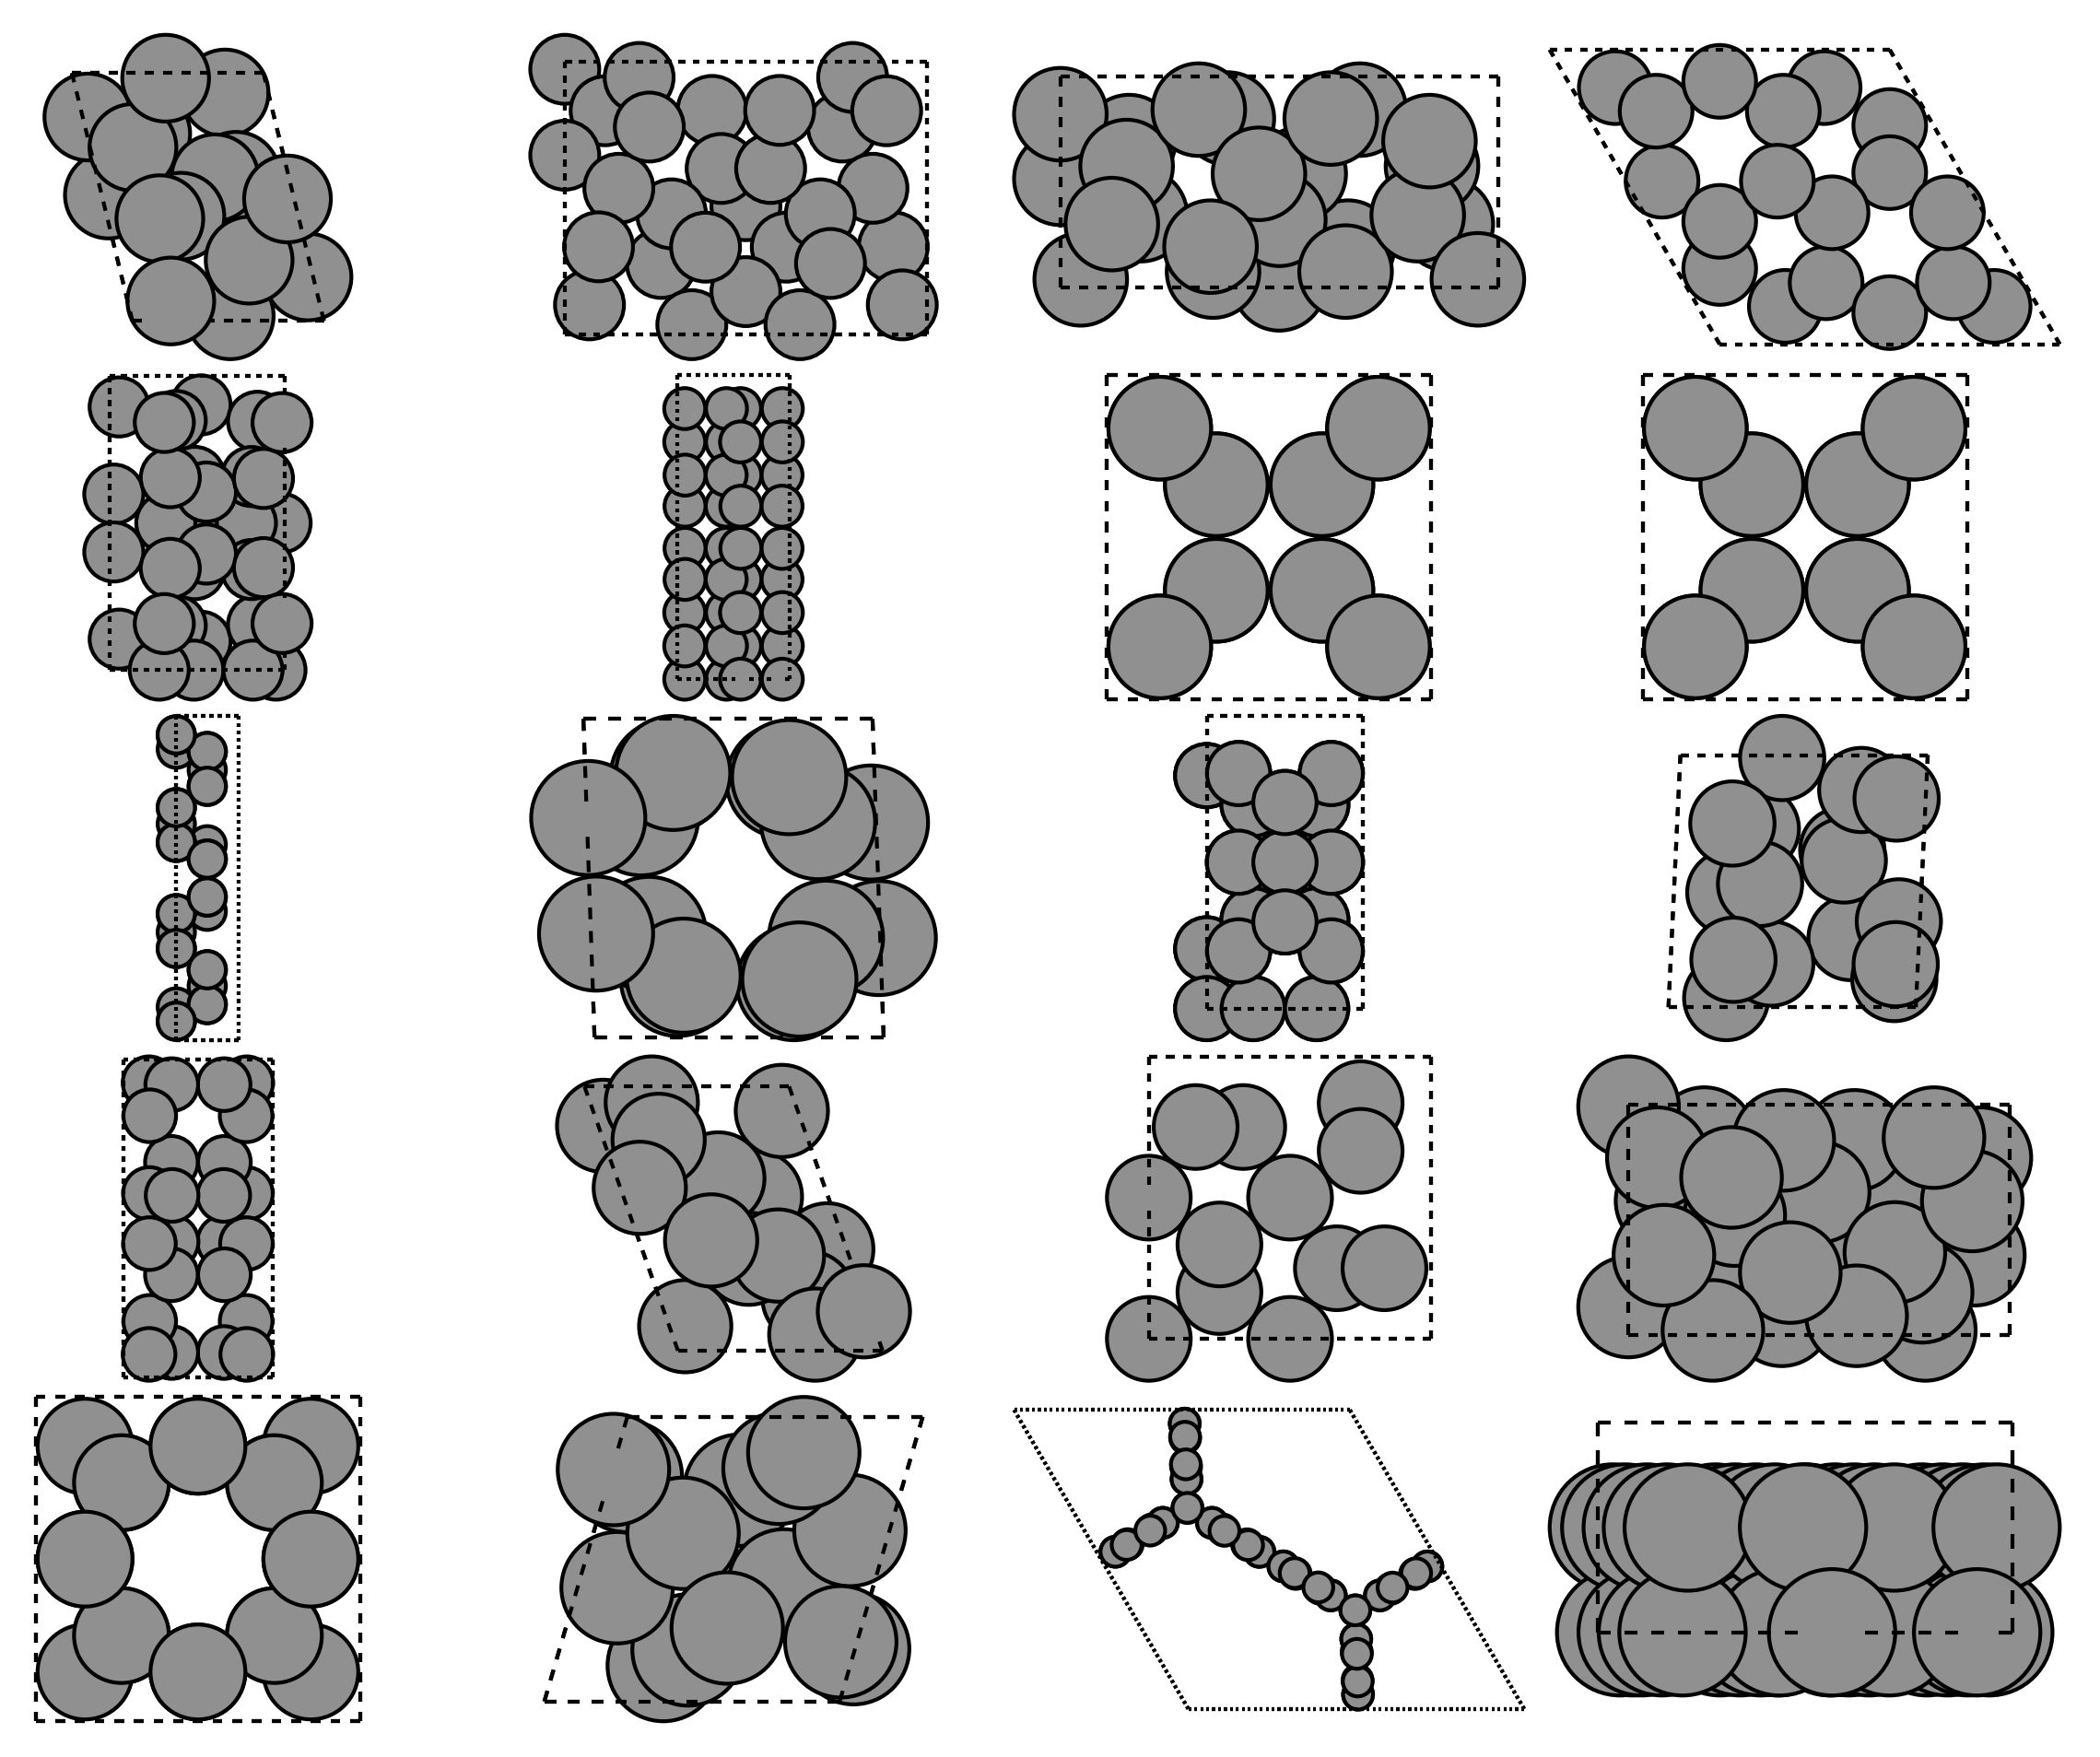

In [71]:
fig, axes = plt.subplots(5, 6, figsize = (5*2, 4*2), gridspec_kw={'hspace': 0, 'wspace': 0})

iax = 0
for i in range(5):
    for j in range(4):
        axes[i,j].axis('off')
        f = frames[iax+140]
        f.wrap()
        plot_atoms(f, ax = axes[i,j], show_unit_cell = 2)
        iax+=1

In [13]:
recon_HT = blocks_to_matrix(test_target)

NameError: name 'test_target' is not defined

In [15]:
# test_target = mts.load(f'{root}/test/test_HT_blocks')
# test_target0 = mts.load(f'{root}/test/test_H0T_blocks')

# recon_HT = blocks_to_matrix(test_target)
# recon_H0T

RMSE = {}
MAE = {}
for train_folder in glob(f'{root}/models_*'):
    nstruc = int(train_folder.split('/')[-1].split('_')[2])
    print(f'    {nstruc} {train_folder}')

    try:
        # Training target
        train_target = mts.load(f'{train_folder}/target_coupled_blocks')
        # train_target_baseline = mts.load(f'{train_folder}/target_coupled_blocks')
        
        # Training prediction
        train_prediction = mts.load(f'{train_folder}/predictions_training')
    
        # Test prediction
        test_prediction = mts.load(f'{train_folder}/predictions_test')

        RMSE[nstruc] = {}
        MAE[nstruc] = {}

        RMSE[nstruc]['train'] = rmse_blocks(train_prediction, train_target)
        RMSE[nstruc]['test'] = rmse_blocks(test_prediction, test_target)
    
        MAE[nstruc]['train'] = mae_blocks(train_prediction, train_target)
        MAE[nstruc]['test'] = mae_blocks(test_prediction, test_target)
    except Exception as e:
        print(e)

    100 /scratch/pegolo/allotropes/models_0_100
    120 /scratch/pegolo/allotropes/models_0_120
    140 /scratch/pegolo/allotropes/models_0_140
    20 /scratch/pegolo/allotropes/models_0_20
    40 /scratch/pegolo/allotropes/models_0_40
    60 /scratch/pegolo/allotropes/models_0_60
    80 /scratch/pegolo/allotropes/models_0_80
io error: No such file or directory (os error 2)
    160 /scratch/pegolo/allotropes/models_0_160
io error: No such file or directory (os error 2)
    1 /scratch/pegolo/allotropes/models_0_1


Text(0.5, 1.0, 'Carbon allotropes')

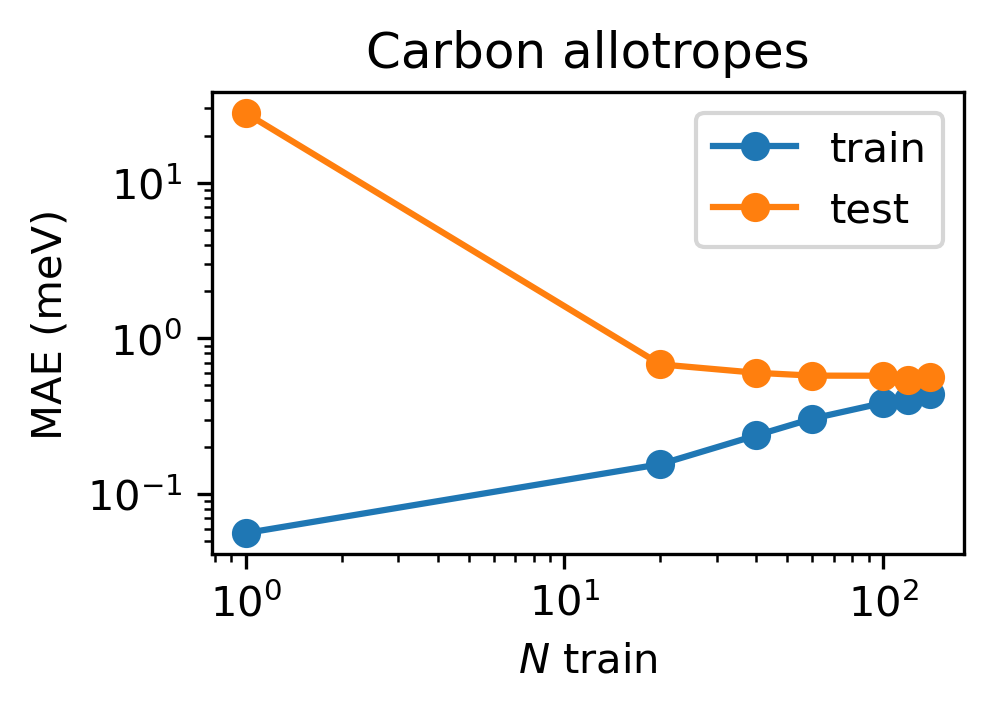

In [104]:
fig, ax = plt.subplots()

# metrics = RMSE
# metrics_name = 'RMSE'

metrics = MAE
metrics_name = 'MAE'

# units_name = 'a.u.'
# units = 1

if metrics_name == 'RMSE':
    metrics = RMSE
elif metrics_name == 'MAE':
    metrics = MAE

from ase.units import Hartree
units_name = 'meV'
units = Hartree*1000

for tset in ['train', 'test']:
    x = np.array([n for n in metrics])
    y = np.array([metrics[n][tset] for n in metrics]) * units
    y = y[x.argsort()]
    x = x[x.argsort()]
    ax.plot(x, y, '-o', label = tset)
    
ax.set_xlabel('$N$ train')
ax.set_ylabel(f'{metrics_name} ({units_name})')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(.9, 500)
# ax.set_ylim(0.1, 30)
ax.set_title('Carbon allotropes')

In [1]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

from ase.units import Hartree

n = 20
xx = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_{n}')
yy = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_pred_{n}')

for x, y in zip(xx, yy):
    ax.plot(x.flatten()[::20]*Hartree, y.flatten()[::20]*Hartree, '.', alpha = 0.5)

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Pred. eigenvalues (eV)')
ax.plot([-275,50], [-275,50], 'K')


print('rmse','{:.2e}'.format(Hartree*1000*np.sqrt(torch.cat([(x.flatten()-y.flatten())**2  for  x, y in zip(xx, yy)]).mean().item())))
print('std','{:.2e}'.format(Hartree*1000*torch.cat([x.flatten()  for  x, y in zip(xx, yy)]).std().item()))
# print('mae',Hartree*1000*np.mean(np.abs(torch.stack(xx)-torch.stack(yy))))
ax.set_xlim(-25,35)
ax.set_ylim(-25,35)

NameError: name 'plt' is not defined

rmse 1.61e+02
std 1.06e+05


(-25.0, 35.0)

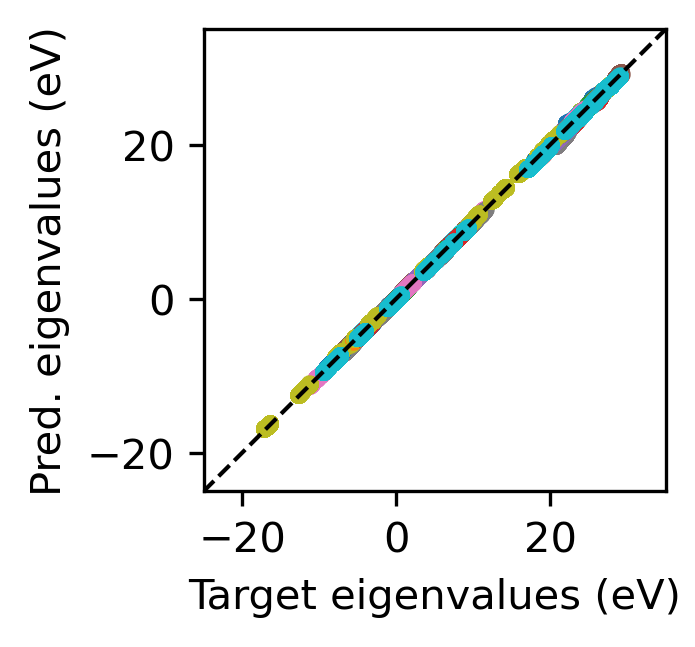

In [8]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

from ase.units import Hartree

n = 140
xx = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_{n}')
yy = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_pred_{n}')

for x, y in zip(xx, yy):
    ax.plot(x.flatten()[::20]*Hartree, y.flatten()[::20]*Hartree, '.', alpha = 0.5)

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Pred. eigenvalues (eV)')
ax.plot([-275,50], [-275,50], 'k', ls = '--', lw = 1)


print('rmse','{:.2e}'.format(Hartree*1000*np.sqrt(torch.cat([(x.flatten()-y.flatten())**2  for  x, y in zip(xx, yy)]).mean().item())))
print('std','{:.2e}'.format(Hartree*1000*torch.cat([x.flatten()  for  x, y in zip(xx, yy)]).std().item()))

ax.set_xlim(-25,35)
ax.set_ylim(-25,35)

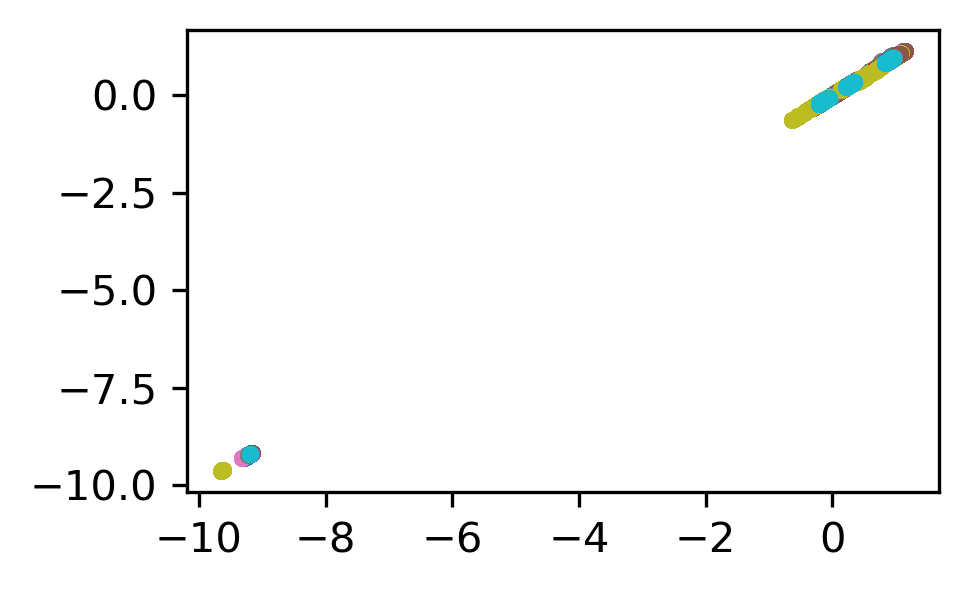

In [30]:
n = 20
xx = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_{n}')
yy = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_pred_{n}')

fig, ax = plt.subplots()

for x, y in zip(xx, yy):
    ax.plot(x.flatten()[::50], y.flatten()[::50], '.', alpha = 0.5)

In [28]:
fs = plt.rcParams['figure.figsize']
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300

(7,) (7,) (7, 2)
(7,) (7,) (7, 2)
rmse 1.61e+02
std 1.06e+05


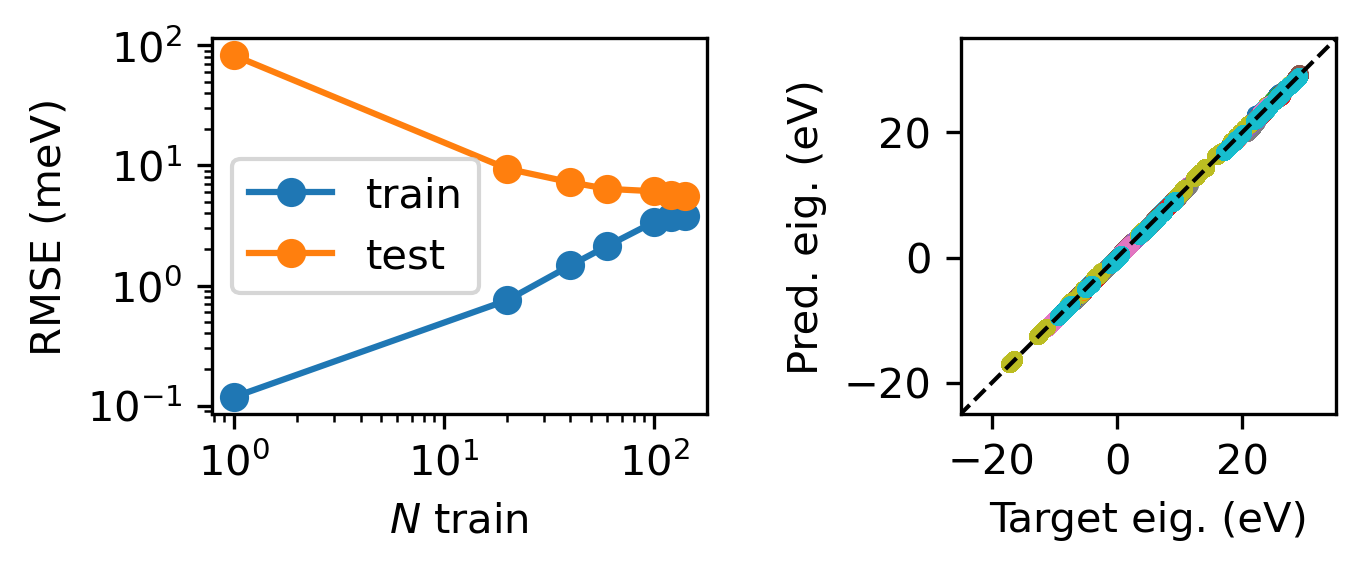

In [51]:
data_allo = {}

fig, axes = plt.subplots(1, 2, figsize = (fs[0]*1.5, fs[1]))

ax = axes[0]
metrics = MAE
metrics_name = 'RMSE'

if metrics_name == 'RMSE':
    metrics = RMSE
elif metrics_name == 'MAE':
    metrics = MAE

from ase.units import Hartree
units_name = 'meV'
units = Hartree*1000

data_allo['RMSE_au'] = {}

for tset in ['train', 'test']:
    x = np.array([n for n in metrics])
    y = np.array([metrics[n][tset] for n in metrics]) * units
    y = y[x.argsort()]
    x = x[x.argsort()]
    print(x.shape, y.shape, np.column_stack([x, y]).shape)
    data_allo['RMSE_au'][tset] = np.column_stack([x, y])
    ax.plot(x, y, '-o', label = tset)
    
ax.set_xlabel('$N$ train')
ax.set_ylabel(f'{metrics_name} ({units_name})')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]

ax.set_aspect('equal')

from ase.units import Hartree

n = 140
xx = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_{n}')
yy = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_pred_{n}')

data_allo['eigenvalues'] = {'target_au': xx, 'prediction_au': yy}

for x, y in zip(xx, yy):
    ax.plot(x.flatten()[::20]*Hartree, y.flatten()[::20]*Hartree, '.', alpha = 0.5)

ax.set_xlabel('Target eig. (eV)')
ax.set_ylabel('Pred. eig. (eV)')
ax.plot([-275,50], [-275,50], 'k', ls = '--', lw = 1)


print('rmse','{:.2e}'.format(Hartree*1000*np.sqrt(torch.cat([(x.flatten()-y.flatten())**2  for  x, y in zip(xx, yy)]).mean().item())))
print('std','{:.2e}'.format(Hartree*1000*torch.cat([x.flatten()  for  x, y in zip(xx, yy)]).std().item()))

ax.set_xlim(-25,35)
ax.set_ylim(-25,35)

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(5, 6, figsize = (5*2, 4*2), gridspec_kw={'hspace': 0, 'wspace': 0})

iax = 0
for i in range(5):
    for j in range(4):
        axes[i,j].axis('off')
        f = frames[iax+140]
        f.wrap()
        plot_atoms(f, ax = axes[i,j], show_unit_cell = 2)
        iax+=1

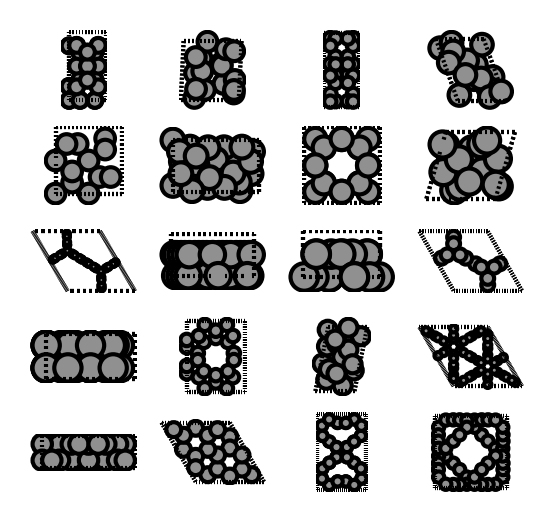

In [67]:
fig = plt.figure()
from matplotlib.gridspec import GridSpec

gs = GridSpec(5, 6, figure = fig)

fff = []
ifr = 150
for i in range(5):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        ax.axis('off')
        f = frames[ifr]
        f.wrap()
        fff.append(f)
        plot_atoms(f, ax = ax, show_unit_cell = 2)
        ifr += 1

# ax1 = fig.add_subplot(gs[, :])
# # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
# ax2 = fig.add_subplot(gs[1, :-1])
# ax3 = fig.add_subplot(gs[1:, -1])
# ax4 = fig.add_subplot(gs[-1, 0])
# ax5 = fig.add_subplot(gs[-1, -2])

In [65]:
from ase.io import write

In [68]:
write('/scratch/pegolo/samsung_report_2024_06/data/allotropes_testset.xyz', fff)

In [52]:
np.save('/scratch/pegolo/samsung_report_2024_06/data/RMSE_and_eigenvalues_allotropes_N140.npy', data_allo)

In [35]:
x.shape

(7,)

In [26]:
n = 140
xx = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_{n}')
yy = hickle.load(f'/scratch/pegolo/allotropes/data/eigvals_test_pred_{n}')

fig, ax = plt.subplots()

for x, y in zip(xx, yy):
    ax.plot(x.flatten(), y.flatten(), '.', alpha = 0.5)

torch.Size([1950, 80])

In [28]:
x.flatten().shape

torch.Size([471900])

In [43]:
torch.cat([x.flatten()  for  x, y in zip(xx, yy)]).std().item()

3.907680996020269

In [ ]:
kmesh = 